## Re-fit ( Re-build and fine-Tune) method:

This method tries to combat the CodeBook collapse, i.e(dead codes phenomenon where only a small subset of codes are used by the encoder from the whole codebook), it was first introduced in the paper : https://arxiv.org/pdf/2112.01799

In the best scenario, We want our codeBook to be initialized in a manner where it has a prior on our dataset, so the codes and the encoders outputs are more alligned, hence the distances between them isn't that huge, The idea proposed in the article is simple : take a pre-trained Vq-Vae trained on a random intilialised codebook, then do a pass through all the dataset and encode allthe images using the encoder, we end by a huge matrix, then we apply a K-means on all the vectors to take the centroids, and train a new model whose codebbok is initialized with those centroids.

We can note the following : 
*   The nw model is still inspired by the previous CodeBook, so note that any enhancement made on the previous can strongly increase the new model, inversely, if we start from a bad model, this mehtod could not help much
*   we can highly decrease the number of codes used in this new model $K' << K$ without loosing much informations. after all, experiments show that only $20 \% $ codes are used form a randomly initialized codebook. 

In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from utils.acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model
from utils.vqVAE import VQVAE
# from vqVAE_custom import VQVAE


import warnings
warnings.filterwarnings("ignore")

/home/ids/ihamdaoui-21/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
in_channels = 4 
L = 128 # image size L=W
BATCH_SIZE = 16

new_K = 256 # We divided the number of codes by 4
D = 64


### Calling the DataSet

In [4]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


In [5]:
train_dataset = load_dataset(train_set_path)
test_dataset  = load_dataset(test_set_path)


input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)

In [6]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [7]:
model_path = 'saved_models/vqvae_100_bestmodel.pth'

model = VQVAE(in_channels, 64, 512)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)


In [8]:
# we are going to pass through the whole dataset, which results on 

latent_vectors = []

# Process the dataset
with torch.no_grad():  # No need to track gradients
    for batch in TrainLoader:
        # Pass the batch through the encoder
        encoded = model.encode(batch.float().to(device))[0]  # Output shape: (batch_size, 32, 32, 32)
        
        # Flatten the encoded output to (batch_size, 32*32)
        encoded_flat = encoded.view(encoded.size(0), 64, -1).permute(0, 2, 1)  # Shape: (batch_size, 1024, 64)
        
        # Now flatten across the batch and spatial dimensions to (batch_size * 1024, 64)
        encoded_flat = encoded_flat.reshape(-1, 64)
        
        # Convert the tensor to NumPy and store it
        latent_vectors.append(encoded_flat.cpu().numpy())

# Concatenate all the latent vectors into a single NumPy array
latent_vectors = np.concatenate(latent_vectors, axis=0)  # Shape: (size_of_dataset, 32*32)

# # Optionally, save the latent vectors to disk
# np.save('latent_vectors.npy', latent_vectors)

In [9]:

from sklearn.cluster import kmeans_plusplus

# Calculate seeds from k-means++
centers_init, indices = kmeans_plusplus(latent_vectors, n_clusters= new_K)


In [10]:
# let's take just P samples from the whole distribution : 
P = 100000

total_vectors = latent_vectors.shape[0]

# Randomly sample N unique indices from the range of total_vectors
sample_indices = np.random.choice(total_vectors, size=P, replace=False)

# Extract the corresponding vectors
latent_vectors_red = latent_vectors[sample_indices, :]  # Shape: (N, 64)

In [12]:
import umap
import numpy as np

reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform
d2_latent_vectors_red = reducer.fit_transform(latent_vectors_red)
d2_centers_init       = reducer.transform(centers_init)



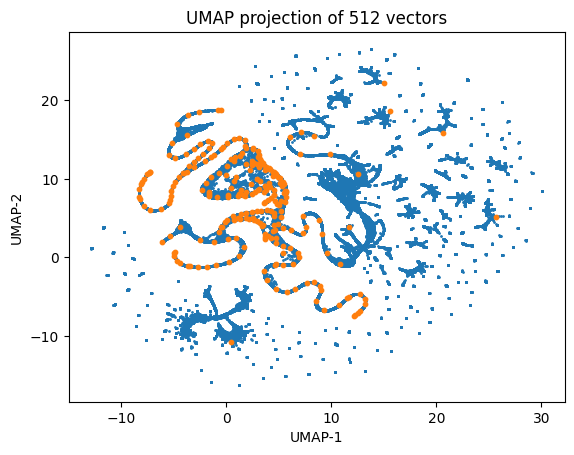

In [13]:
plt.Figure(figsize=(40,40))
# Plot the results
plt.scatter(d2_latent_vectors_red[:, 0], d2_latent_vectors_red[:, 1], s = 1)
plt.scatter(d2_centers_init[:, 0], d2_centers_init[:, 1], s = 10)
plt.title('UMAP projection of 512 vectors')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()



In [14]:
# from utils.training import *

In [15]:
### Learning parameters
new_codebook = torch.from_numpy(centers_init)

ACDC_VQVAE = VQVAE(in_channels, D, new_K, embedding = new_codebook)
model = ACDC_VQVAE.to(device)

lr = 5e-4
epochs = 40
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'Re_Fit_models/vqvae_101_bestmodel.pth'


In [16]:

def reconstruct_logits(batch, model):
    output, _, _, _ = model(batch.float())
    return output



def visualize_batch(batch, title):
    batch_size = batch.shape[0]
    samples = 8


    fig, axes = plt.subplots(samples, 4, figsize=(5, 10))  # Adjust figsize to accommodate more rows
    fig.suptitle(title, fontsize=16)

    for ax in axes.flat:
        ax.set_axis_off()

    for i in range(samples):

        img = batch[i]
        axes[i,0].imshow(img[0,:,:], cmap = 'gray', vmin=0, vmax=1)
        axes[i,1].imshow(img[1,:,:], cmap = 'gray', vmin=0, vmax=1)
        axes[i,2].imshow(img[2,:,:], cmap = 'gray', vmin=0, vmax=1)
        axes[i,3].imshow(img[3,:,:], cmap = 'gray', vmin=0, vmax=1)
        # axes[i].axis('off')

    
    # plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()




def visualize_batch_logits(batch, title):
    batch_size = batch.shape[0]
    samples = 8


    fig, axes = plt.subplots(samples, 4, figsize=(10, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle(title, fontsize=16)

    for ax in axes.flat:
        ax.set_axis_off()

    for i in range(samples):

        img = batch[i]
        axes[i,0].imshow(img[0,:,:], cmap = 'gray')
        axes[i,1].imshow(img[1,:,:], cmap = 'gray')
        axes[i,2].imshow(img[2,:,:], cmap = 'gray')
        axes[i,3].imshow(img[3,:,:], cmap = 'gray')
        # axes[i].axis('off')

    
    # plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



def visualize_errors(true_segs, pred_segs, title):
    # batch_size = batch.shape[0]
    samples = 8

    custom_colors = [
    '#000000', '#ff0000', '#ffd700', '#00ffff']
    cmap = ListedColormap(custom_colors)
    # error_cmap = LinearSegmentedColormap.from_list('black_red', ['black', 'red'], N=256)

    error_mask = torch.where(true_segs != pred_seg, 1, 0)

    fig, axes = plt.subplots(samples, 3, figsize=(8, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle(title, fontsize=16)


    for i in range(samples):
        axes[i,0].imshow(true_seg[i], cmap = cmap)
        axes[i,0].axis('off')

        axes[i,1].imshow(pred_segs[i], cmap = cmap)
        axes[i,1].axis('off')

        axes[i,2].imshow(error_mask[i], cmap = 'magma')
        axes[i,2].axis('off')

    row_titles = ['Ground truth', 'Vq-Vae predictions', 'Pixel Errors']
    for i in range(3):
        axes[0, i].set_title(row_titles[i], fontsize=14, fontweight='bold')
    
    # plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



def dice_loss_hard(preds, targets, smooth=1e-6):
    """
    Calculate Dice Loss across the 4 segmentation channels using binary masks.
    :param preds: Predicted output tensor of shape [batch_size, 4, height, width] (logits or soft predictions)
    :param targets: Ground truth one-hot tensor of shape [batch_size, 4, height, width]
    :param smooth: A small value to avoid division by zero
    :return: Dice Loss (scalar)
    """
    # Apply softmax over channel dimension (4 channels) to convert logits to probabilities
    preds = F.softmax(preds, dim=1)

    # Convert probabilities to binary one-hot predictions by using argmax and one-hot encoding
    preds_bin = torch.argmax(preds, dim=1)  # Shape: [batch_size, height, width] (class index for each pixel)
    preds_onehot = F.one_hot(preds_bin, num_classes=4).permute(0, 3, 1, 2).float()  # Shape: [batch_size, 4, height, width]

    # Flatten predictions and targets for dice coefficient calculation
    preds_flat = preds_onehot.contiguous().view(preds_onehot.shape[0], preds_onehot.shape[1], -1)  # [batch_size, 4, height*width]
    targets_flat = targets.contiguous().view(targets.shape[0], targets.shape[1], -1)  # [batch_size, 4, height*width]

    # Calculate intersection and union
    intersection = (preds_flat * targets_flat).sum(dim=2)  # Summing over height and width dimensions
    union = preds_flat.sum(dim=2) + targets_flat.sum(dim=2)  # Sum of both sets

    # Calculate Dice coefficient and Dice loss
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)  # Dice coefficient per channel
    dice_loss = 1 - dice_coeff.mean()  # Average over the batch and channels

    return dice_loss




def evaluate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch.float().to(device)
           
            outputs, _, _, _ = model(inputs)
            outputs_binary = F.softmax(outputs, dim=1)
            
            # Loss and backward
            loss = dice_loss_hard(inputs, outputs)
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    return avg_val_loss


def save_model(model_name, model, epoch, train_loss_values, val_loss_values, codebook_loss_values):
    checkpoint_path = os.path.join( os.getcwd() , model_name )
    torch.save({'epoch' : epoch,
                'K' : model.vq_layer.K,
                'D' :  model.vq_layer.D,
                'model_state_dict' : model.state_dict(),
                'train_loss_values' : train_loss_values, 
                'val_loss_values' : val_loss_values, 
                'codebook_loss_values' : codebook_loss_values,
                'codebook' : model.vq_layer.embedding.weight.data }, checkpoint_path)


In [17]:
# visualisation batch, to track th eperformance of the model
vis_batch = next(iter(TestLoader)).to(device)

model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader)
    val_loss_values.append(val_loss)

    #track output precision progression every 10 epoch:
    if (epoch%5 == 0 and epoch<50):
        output, _, _, _ = model( vis_batch.float() )
        recons_evolution.append(output)


    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model_name, model,  epoch, train_loss_values, val_loss_values, codebook_loss_values)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

  0%|          | 0/119 [00:00<?, ?batch/s]

100%|██████████| 119/119 [00:06<00:00, 17.52batch/s, loss=3.08]  


Epoch 0: Train Loss: 218.7380


100%|██████████| 119/119 [00:06<00:00, 17.46batch/s, loss=3.65]  


Epoch 1: Train Loss: 993.6528


100%|██████████| 119/119 [00:06<00:00, 18.66batch/s, loss=78]  


Epoch 2: Train Loss: 81.1304


100%|██████████| 119/119 [00:06<00:00, 19.26batch/s, loss=1.36]  


Epoch 3: Train Loss: 135.1575


100%|██████████| 119/119 [00:05<00:00, 19.94batch/s, loss=0.454]


Epoch 4: Train Loss: 1.9002


100%|██████████| 119/119 [00:05<00:00, 20.07batch/s, loss=1.35] 


Epoch 5: Train Loss: 0.6422


100%|██████████| 119/119 [00:05<00:00, 20.51batch/s, loss=2.18]


Epoch 6: Train Loss: 5.6755


100%|██████████| 119/119 [00:05<00:00, 20.10batch/s, loss=2.08]


Epoch 7: Train Loss: 1.9856


100%|██████████| 119/119 [00:06<00:00, 19.52batch/s, loss=0.113] 


Epoch 8: Train Loss: 0.2539


100%|██████████| 119/119 [00:05<00:00, 20.33batch/s, loss=0.0631]


Epoch 9: Train Loss: 0.0856


100%|██████████| 119/119 [00:06<00:00, 19.19batch/s, loss=0.047] 


Epoch 10: Train Loss: 0.0578


100%|██████████| 119/119 [00:05<00:00, 19.98batch/s, loss=0.0527]


Epoch 11: Train Loss: 0.0499


100%|██████████| 119/119 [00:05<00:00, 20.01batch/s, loss=0.0446]


Epoch 12: Train Loss: 0.0459


100%|██████████| 119/119 [00:05<00:00, 20.30batch/s, loss=0.0446]


Epoch 13: Train Loss: 0.0435


100%|██████████| 119/119 [00:06<00:00, 19.72batch/s, loss=0.0458]


Epoch 14: Train Loss: 0.0421


100%|██████████| 119/119 [00:05<00:00, 20.38batch/s, loss=0.0393]


Epoch 15: Train Loss: 0.0416


100%|██████████| 119/119 [00:06<00:00, 19.53batch/s, loss=0.0366]


Epoch 16: Train Loss: 0.0393


100%|██████████| 119/119 [00:06<00:00, 19.16batch/s, loss=0.0398]


Epoch 17: Train Loss: 0.0377


100%|██████████| 119/119 [00:06<00:00, 19.78batch/s, loss=0.0333]


Epoch 18: Train Loss: 0.0363


100%|██████████| 119/119 [00:06<00:00, 19.65batch/s, loss=0.0321]


Epoch 19: Train Loss: 0.0348


100%|██████████| 119/119 [00:06<00:00, 19.55batch/s, loss=0.0375]


Epoch 20: Train Loss: 0.0331


100%|██████████| 119/119 [00:05<00:00, 20.17batch/s, loss=0.0329]


Epoch 21: Train Loss: 0.0320


100%|██████████| 119/119 [00:05<00:00, 20.29batch/s, loss=0.034] 


Epoch 22: Train Loss: 0.0315


100%|██████████| 119/119 [00:06<00:00, 19.47batch/s, loss=0.0332]


Epoch 23: Train Loss: 0.0308


100%|██████████| 119/119 [00:05<00:00, 20.52batch/s, loss=0.0305]


Epoch 24: Train Loss: 0.0304


100%|██████████| 119/119 [00:06<00:00, 19.24batch/s, loss=0.0302]


Epoch 25: Train Loss: 0.0298


100%|██████████| 119/119 [00:06<00:00, 19.54batch/s, loss=0.032] 


Epoch 26: Train Loss: 0.0294


100%|██████████| 119/119 [00:06<00:00, 19.63batch/s, loss=0.0193]


Epoch 27: Train Loss: 0.0291


100%|██████████| 119/119 [00:06<00:00, 19.20batch/s, loss=0.0232]


Epoch 28: Train Loss: 0.0289


100%|██████████| 119/119 [00:06<00:00, 19.62batch/s, loss=0.0323]


Epoch 29: Train Loss: 0.0285


100%|██████████| 119/119 [00:05<00:00, 19.95batch/s, loss=0.0281]


Epoch 30: Train Loss: 0.0280


100%|██████████| 119/119 [00:05<00:00, 19.88batch/s, loss=0.0289]


Epoch 31: Train Loss: 0.0275


100%|██████████| 119/119 [00:05<00:00, 19.85batch/s, loss=0.0253]


Epoch 32: Train Loss: 0.0271


100%|██████████| 119/119 [00:05<00:00, 19.95batch/s, loss=0.0264]


Epoch 33: Train Loss: 0.0267


100%|██████████| 119/119 [00:06<00:00, 18.36batch/s, loss=0.0221]


Epoch 34: Train Loss: 0.0264


100%|██████████| 119/119 [00:06<00:00, 19.32batch/s, loss=0.0293]


Epoch 35: Train Loss: 0.0262


100%|██████████| 119/119 [00:05<00:00, 19.88batch/s, loss=0.024] 


Epoch 36: Train Loss: 0.0260


100%|██████████| 119/119 [00:06<00:00, 19.55batch/s, loss=0.0291]


Epoch 37: Train Loss: 0.0257


100%|██████████| 119/119 [00:06<00:00, 19.38batch/s, loss=0.0197]


Epoch 38: Train Loss: 0.0256


100%|██████████| 119/119 [00:05<00:00, 20.38batch/s, loss=0.0257]


Epoch 39: Train Loss: 0.0256
Training complete.
